# Work Flow For Google News 300 with CNN

1. x_train: \[text1, text2, ...\]
   y_train: \[label1, label2, ...\]

2. Generate vocabulary set and get token_to_id map. This map will map a word to an index in vocabulary space. Transform text to \[index1, index2, ..., \]. 

   Padded sequences to fixed length (750, )
    
3. Word Vector - Google News 300

4. CNN model

The accuracy is 0.81.

In [245]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
%autoreload

In [247]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [248]:
from src.data_preprocess.preprocess import DataProcessor
data_preprocessor = DataProcessor()
train_documents, test_documents = data_preprocessor.get_train_and_test_documents()

========== Extract data from pickle files ==========


In [261]:
from nltk.tokenize import word_tokenize
x_train = []
y_train = []
x_test = []
y_test = []
bag_of_classes = set()

for document in train_documents:
    bag_of_classes.add(document.class_list[0])
    tokens, tf = data_preprocessor.convert_text_to_word_list(document.text)
    x_train.append(' '.join(tokens))
    y_train.append(document.class_list[0])
        
for document in test_documents:
    for class_ in document.class_list:
        if class_ in bag_of_classes:
            tokens, tf = data_preprocessor.convert_text_to_word_list(document.text)
            x_test.append(' '.join(tokens))
            y_test.append(class_)
            break

len(x_train), len(y_train), len(x_test), len(y_test)

(7310, 7310, 3347, 3347)

In [262]:
x_train[300]

'summit petroleum corp sells shares abilene texas march summit petroleum corp sold shares common stock halbert associates company shares previously held consolidated energy corp harken hogi addition david halbert president chief executive officer halbert abilene investment firm named chairman chief executive summit company halbert charles bruce james burke named directors expanding board summit added company burke president chief executive allied comprehensive health abilene bruce partner washington firm butler binion summit intends actively seek acquisitions increase asset base reuter'

# Convert text to vector

In [263]:
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train+x_test)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [264]:
word_index = tokenizer.word_index
len(word_index)

28451

In [265]:
max(word_index.values())

28451

In [267]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 750

data_train_X = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
data_test_X = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
data_train_X.shape, data_test_X.shape

((7310, 750), (3347, 750))

In [268]:
data_train_X[300]

array([ 1835,   217,    12,   705,    16, 11530,   270,     3,  1835,
         217,    12,   208,    16,    69,    17,  9967,   969,     9,
          16,   216,   219,   810,   197,    12, 17983, 17984,   555,
        1151,  9967,    96,   401,   362,   775,  9967, 11530,    84,
         198,   918,   132,   401,   362,  1835,     9,  9967,  1978,
        4258,   702,  9968,   918,   562,  2017,    59,  1835,    60,
           9,  9968,    96,   401,   362,   778,  3138,   795, 11530,
        4258,  1619,    47,   198,  5227, 17985,  1835,  1149,  2261,
         577,   686,    58,  1199,   357,     2,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [269]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [270]:
y_train_vector = lb.transform(y_train)
y_test_vector = lb.transform(y_test)
y_train_vector[::300], y_test_vector.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]), (3347, 73))

In [271]:
from sklearn.model_selection import train_test_split

train_X, val_x, train_y, val_y = train_test_split(data_train_X, y_train_vector, test_size=0.2, random_state=65)

data_test_y = y_test_vector

# Build word vector matrix

In [202]:
# Use Google News 300 dimension word vector
from gensim.models import KeyedVectors
filename = '~/gensim-data/GoogleNews-300/GoogleNews-vectors-negative300.bin'
embedding_wv_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [272]:
EMBEDDING_DIM = embedding_wv_model.vector_size
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embedding_wv_model.vocab:
        embedding_matrix[i] = embedding_wv_model.get_vector(word)

In [273]:
embedding_matrix[200]

array([-7.95898438e-02,  1.41601562e-01, -1.26953125e-01,  1.09863281e-01,
       -1.92382812e-01,  6.07910156e-02,  1.47460938e-01,  7.95898438e-02,
        1.07421875e-01, -1.05957031e-01, -2.07031250e-01, -3.22265625e-02,
       -5.95703125e-02,  1.84570312e-01, -2.21679688e-01, -4.37011719e-02,
       -1.46484375e-01,  3.76953125e-01, -1.25000000e-01,  1.26953125e-01,
       -1.40625000e-01,  1.13769531e-01,  5.51757812e-02, -3.08837891e-02,
        1.07910156e-01,  5.44433594e-02, -1.49414062e-01, -1.29882812e-01,
       -3.14453125e-01,  8.15429688e-02,  2.63671875e-01, -3.73535156e-02,
       -2.40234375e-01, -8.17871094e-03, -1.78710938e-01,  4.76074219e-02,
        8.23974609e-03, -1.73339844e-02,  4.32128906e-02,  1.40625000e-01,
        6.88476562e-02,  1.40625000e-01,  4.83398438e-02, -1.18164062e-01,
       -1.31835938e-01, -1.67968750e-01,  1.54296875e-01, -3.93066406e-02,
        2.01416016e-03,  1.93359375e-01,  2.25585938e-01, -9.47265625e-02,
        6.78710938e-02, -

# Training NN model part

If there is a saved model, you can jump to [load model](#Load-model)

In [206]:
import keras
import keras.layers as L
from keras.models import Model

In [276]:
input_layer = L.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
l_emd = L.Embedding(input_dim=len(word_index)+1, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    trainable=False)(input_layer)
l_conv1 = L.Conv1D(64, 2, activation='relu')(l_emd)
l_maxpool1 = L.GlobalMaxPool1D()(l_conv1)

l_conv2 = L.Conv1D(64, 3, activation='relu')(l_emd)
l_maxpool2 = L.GlobalMaxPool1D()(l_conv2)

l_conv3 = L.Conv1D(64, 5, activation='relu')(l_emd)
l_maxpool3 = L.GlobalMaxPool1D()(l_conv3)

l_combined = L.Concatenate()([l_maxpool1, l_maxpool2, l_maxpool3])

l_dense = L.Dense(128, activation='relu')(l_combined)
output = L.Dense(y_train_vector.shape[1], activation='softmax')(l_dense)

model = Model(input_layer, output)

#model.add(L.Conv1D(128, kernel_size = 3, activation='relu'))
#model.add(L.MaxPooling1D())
#model.add(L.Dense(64, activation='relu'))
#model.add(layers.Dense(46, activation='softmax'))
#model.add(L.Dense(y_train_vector.shape[1], activation='sigmoid'))

In [277]:
l_conv3.shape

TensorShape([Dimension(None), Dimension(746), Dimension(64)])

In [278]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [279]:
batch_size = 256
epochs = 15

history = model.fit(train_X, 
          train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y))

Train on 5848 samples, validate on 1462 samples
Epoch 1/15
5848/5848 [==============================] - 104s 18ms/step - loss: 2.0159 - acc: 0.5378 - val_loss: 1.3852 - val_acc: 0.6902
Epoch 2/15
5848/5848 [==============================] - 101s 17ms/step - loss: 1.1928 - acc: 0.7283 - val_loss: 1.0350 - val_acc: 0.7435
Epoch 3/15
5848/5848 [==============================] - 103s 18ms/step - loss: 0.8837 - acc: 0.7876 - val_loss: 0.9026 - val_acc: 0.7914
Epoch 4/15
5848/5848 [==============================] - 103s 18ms/step - loss: 0.6749 - acc: 0.8435 - val_loss: 0.6945 - val_acc: 0.8420
Epoch 5/15
5848/5848 [==============================] - 104s 18ms/step - loss: 0.5380 - acc: 0.8782 - val_loss: 0.6015 - val_acc: 0.8543
Epoch 6/15
5848/5848 [==============================] - 103s 18ms/step - loss: 0.4227 - acc: 0.9005 - val_loss: 0.5425 - val_acc: 0.8762
Epoch 7/15
5848/5848 [==============================] - 101s 17ms/step - loss: 0.3350 - acc: 0.9251 - val_loss: 0.5257 - val_acc: 

In [284]:
model.save('model/model-nn-GoogleNews-cnn-{}-0.81.h5'.format(datetime.datetime.today()))

# Plot loss for training dataset and validation dataset

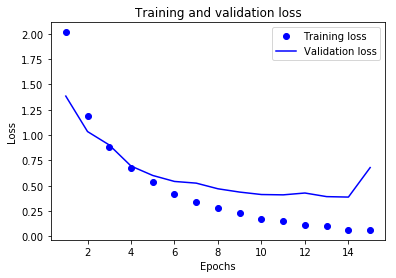

In [281]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Google-News-300-loss.svg')
plt.show()


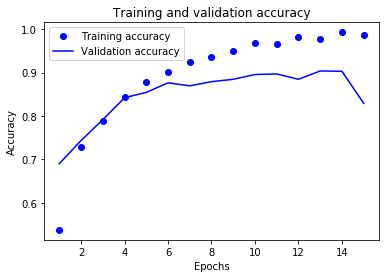

In [282]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Google-News-300-acc.svg')
plt.show()


# Load model

In [ ]:
from keras.models import load_model
model = load_model('model/model-vocabulary-nn.h5')

In [283]:
score, acc = model.evaluate(data_test_X, data_test_y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

3347/3347 [==============================] - 19s 6ms/step
Test score: 0.7448312349023126
Test accuracy: 0.8141619362224206


In [192]:
y_pred = model.predict(x=data_test_X)

In [193]:
y_pred_label = np.zeros_like(y_pred)
y_pred_label[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

In [194]:
y_pred_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [195]:
y_pred_label.shape

(3347, 73)

In [196]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_label, data_test_y)

0.6235434717657604